# Chat GPT

In [11]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO
from pyro.optim import Adam
import torch.distributions.constraints as constraints

class BayesianNN(torch.nn.Module):
    def __init__(self, input_dim=1, hidden_dim=10, output_dim=1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def model(self, x, y=None):
        # PRIOR over w1, b1
        w1 = pyro.sample(
            "w1",
            dist.Normal(
                torch.zeros(self.input_dim, self.hidden_dim),
                torch.ones(self.input_dim, self.hidden_dim)
            ).to_event(2)   # <-- treat (input_dim, hidden_dim) as event dims
        )
        b1 = pyro.sample(
            "b1",
            dist.Normal(
                torch.zeros(self.hidden_dim),
                torch.ones(self.hidden_dim)
            ).to_event(1)   # <-- treat (hidden_dim) as an event dim
        )

        # PRIOR over w2, b2
        w2 = pyro.sample(
            "w2",
            dist.Normal(
                torch.zeros(self.hidden_dim, self.output_dim),
                torch.ones(self.hidden_dim, self.output_dim)
            ).to_event(2)
        )
        b2 = pyro.sample(
            "b2",
            dist.Normal(
                torch.zeros(self.output_dim),
                torch.ones(self.output_dim)
            ).to_event(1)
        )

        # Forward pass
        hidden = torch.relu(x.matmul(w1) + b1)
        pred = hidden.matmul(w2) + b2  # shape [N,1]
        with pyro.plate("data_plate", x.shape[0], dim=-2):
            pyro.sample(
                "obs",
                dist.Normal(pred, 1.0).to_event(1),  # event=1 dimension
                obs=y
            )
    def guide(self, x, y=None):
        # w1
        w1_loc = pyro.param("w1_loc", torch.randn(self.input_dim, self.hidden_dim))
        w1_scale = pyro.param(
            "w1_scale",
            0.1 * torch.ones(self.input_dim, self.hidden_dim),
            constraint=constraints.positive
        )
        pyro.sample(
            "w1",
            dist.Normal(w1_loc, w1_scale).to_event(2)  # match model shape
        )

        # b1
        b1_loc = pyro.param("b1_loc", torch.randn(self.hidden_dim))
        b1_scale = pyro.param(
            "b1_scale",
            0.1 * torch.ones(self.hidden_dim),
            constraint=constraints.positive
        )
        pyro.sample(
            "b1",
            dist.Normal(b1_loc, b1_scale).to_event(1)  # match model shape
        )

        # w2
        w2_loc = pyro.param("w2_loc", torch.randn(self.hidden_dim, self.output_dim))
        w2_scale = pyro.param(
            "w2_scale",
            0.1 * torch.ones(self.hidden_dim, self.output_dim),
            constraint=constraints.positive
        )
        pyro.sample(
            "w2",
            dist.Normal(w2_loc, w2_scale).to_event(2)
        )

        # b2
        b2_loc = pyro.param("b2_loc", torch.randn(self.output_dim))
        b2_scale = pyro.param(
            "b2_scale",
            0.1 * torch.ones(self.output_dim),
            constraint=constraints.positive
        )
        pyro.sample(
            "b2",
            dist.Normal(b2_loc, b2_scale).to_event(1)
        )

# -------------------------------------------------
# Instantiate Bayesian NN
bayes_nn = BayesianNN()

# Generate toy data, e.g. y = 2*x + noise
N = 50
x_data = torch.linspace(-3, 3, N).reshape(-1, 1)
y_data = 2.0 * x_data + 0.3 * torch.randn_like(x_data)

# SVI
svi = SVI(
    model=bayes_nn.model,
    guide=bayes_nn.guide,
    optim=Adam({"lr": 0.01}),
    loss=TraceMeanField_ELBO()
)

num_steps = 2000
for step in range(num_steps):
    loss = svi.step(x_data, y_data)
    if step % 200 == 0:
        print(f"Step {step}, loss={loss:.4f}")

print("Training complete!")

# Posterior Sampling
x_star = torch.tensor([[1.5]])
num_samples = 100
predictions = []
for _ in range(num_samples):
    with pyro.poutine.trace() as tr:
        bayes_nn.guide(x_star)
    sampled_params = {name: site["value"] for name, site in tr.trace.nodes.items() if site["type"] == "sample"}

    w1_ = sampled_params["w1"]
    b1_ = sampled_params["b1"]
    w2_ = sampled_params["w2"]
    b2_ = sampled_params["b2"]

    hidden_ = torch.relu(x_star.matmul(w1_) + b1_)
    pred_ = hidden_.matmul(w2_) + b2_
    predictions.append(pred_.item())

mean_pred = torch.mean(torch.tensor(predictions))
std_pred = torch.std(torch.tensor(predictions))
print(f"Predictive mean = {mean_pred:.3f}, predictive std = {std_pred:.3f}")


Step 0, loss=21631.5020
Step 200, loss=17931.3984
Step 400, loss=4251.8013
Step 600, loss=5902.5889
Step 800, loss=4287.6040
Step 1000, loss=2803.9814
Step 1200, loss=4751.4194
Step 1400, loss=2947.7781
Step 1600, loss=2798.3818
Step 1800, loss=2668.1311
Training complete!
Predictive mean = 3.130, predictive std = 0.301


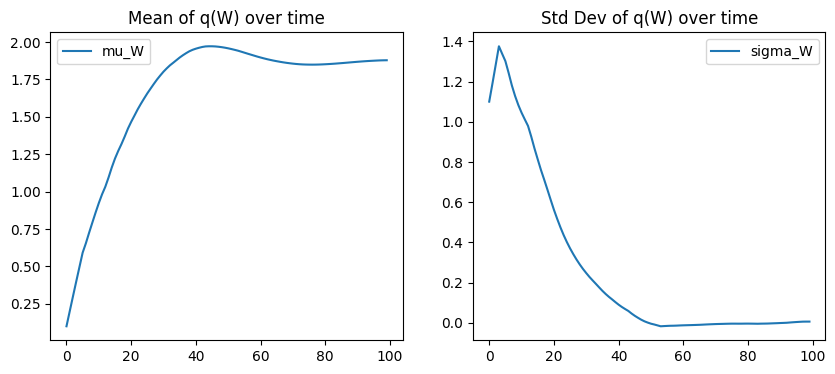

In [7]:
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the prior: p(W) = N(0,1)
def log_prior(w):
    return -0.5 * (w ** 2)  # log PDF of N(0,1), ignoring constant terms

# Define the likelihood: p(D | W) (assume simple quadratic loss)
def log_likelihood(w, x, y):
    y_pred = w * x  # Simple linear model
    return -0.5 * ((y - y_pred) ** 2).sum()  # Gaussian likelihood

# Variational distribution q(W) = N(mu_W, sigma_W^2)
mu_W = torch.tensor(0.0, requires_grad=True)
sigma_W = torch.tensor(1.0, requires_grad=True)

# Data: simple linear relationship y = 2x + noise
x_data = torch.tensor([1.0, 2.0, 3.0])
y_data = torch.tensor([2.2, 3.8, 6.1])

# Optimizer (gradient-based update of variational parameters)
optimizer = torch.optim.Adam([mu_W, sigma_W], lr=0.1)

# Track progress
mu_values, sigma_values = [], []

# Training loop
for step in range(100):
    # Sample weight from q(W)
    w_sample = mu_W + sigma_W * torch.randn(1)  # Reparameterization trick
    
    # Compute ELBO estimate
    log_p = log_prior(w_sample) + log_likelihood(w_sample, x_data, y_data)
    log_q = -0.5 * ((w_sample - mu_W) / sigma_W) ** 2  # log PDF of q(W)
    elbo = log_p - log_q  # Maximize ELBO
    
    # Gradient ascent
    optimizer.zero_grad()
    (-elbo).backward()  # We minimize -ELBO
    optimizer.step()
    
    # Track values
    mu_values.append(mu_W.item())
    sigma_values.append(sigma_W.item())

# Plot results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(mu_values, label='mu_W')
plt.title('Mean of q(W) over time')
plt.legend()

plt.subplot(1,2,2)
plt.plot(sigma_values, label='sigma_W')
plt.title('Std Dev of q(W) over time')
plt.legend()
plt.show()


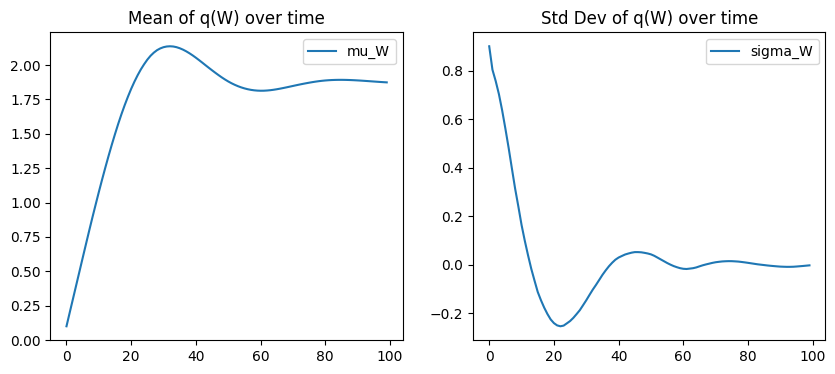

In [15]:
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the prior: p(W) = N(0,1)
def log_prior(w):
    return -0.5 * (w ** 2)  # log PDF of N(0,1), ignoring constant terms

# Define the likelihood: p(D | W) (assume simple quadratic loss)
def log_likelihood(w, x, y):
    y_pred = w * x  # Simple linear model
    return -0.5 * ((y - y_pred) ** 2).sum()  # Gaussian likelihood

# Variational distribution q(W) = N(mu_W, sigma_W^2)
mu_W = torch.tensor(0.0, requires_grad=True)
sigma_W = torch.tensor(1.0, requires_grad=True)

# Data: simple linear relationship y = 2x + noise
x_data = torch.tensor([1.0, 2.0, 3.0])
y_data = torch.tensor([2.2, 3.8, 6.1])

# Optimizer (gradient-based update of variational parameters)
optimizer = torch.optim.Adam([mu_W, sigma_W], lr=0.1)

# Number of samples per iteration
S = 10  # Increase for better ELBO estimation

# Track progress
mu_values, sigma_values = [], []

# Training loop
for step in range(100):
    elbo_samples = []
    
    for _ in range(S):
        # Sample weight from q(W)
        w_sample = mu_W + sigma_W * torch.randn(1)  # Reparameterization trick
        
        # Compute ELBO estimate
        log_p = log_prior(w_sample) + log_likelihood(w_sample, x_data, y_data)
        log_q = -0.5 * ((w_sample - mu_W) / sigma_W) ** 2  # log PDF of q(W)
        elbo_samples.append(log_p - log_q)
    
    # Average ELBO over multiple samples
    elbo = torch.stack(elbo_samples).mean()
    
    # Gradient ascent
    optimizer.zero_grad()
    (-elbo).backward()  # We minimize -ELBO
    optimizer.step()
    
    # Track values
    mu_values.append(mu_W.item())
    sigma_values.append(sigma_W.item())

# Plot results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(mu_values, label='mu_W')
plt.title('Mean of q(W) over time')
plt.legend()

plt.subplot(1,2,2)
plt.plot(sigma_values, label='sigma_W')
plt.title('Std Dev of q(W) over time')
plt.legend()
plt.show()

Epoch [100/500], Loss: 556.2903 (NLL=543.8978, KL=12.3924)
Epoch [200/500], Loss: 120.5182 (NLL=100.5938, KL=19.9244)
Epoch [300/500], Loss: 101.7238 (NLL=75.9804, KL=25.7434)
Epoch [400/500], Loss: 48.7823 (NLL=19.8159, KL=28.9663)
Epoch [500/500], Loss: 80.2480 (NLL=49.4799, KL=30.7681)


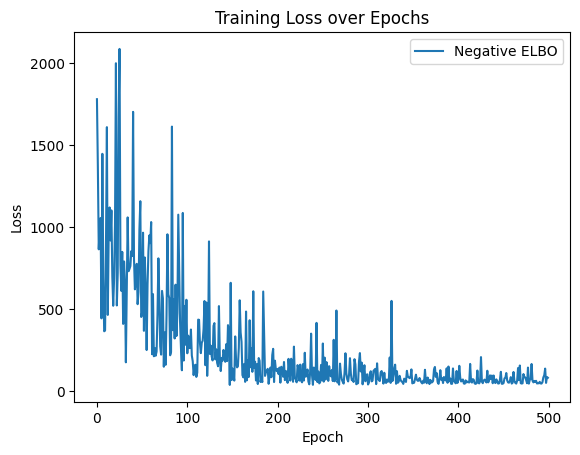

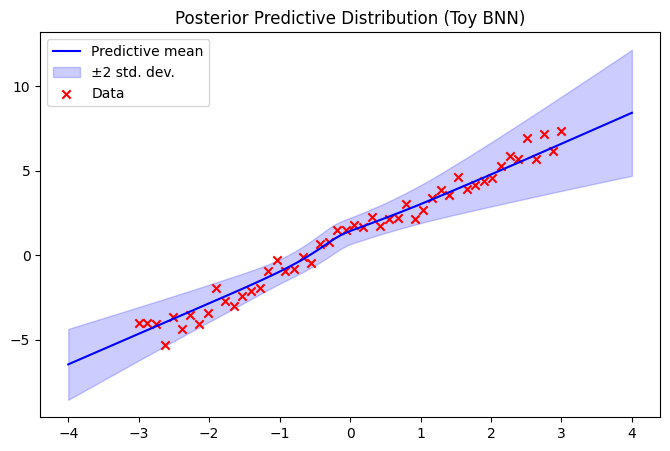

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------
# BayesianLinear Layer
# -------------------------
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Mean and rho for weights
        self.mu_W = nn.Parameter(torch.zeros(out_features, in_features))
        self.rho_W = nn.Parameter(torch.zeros(out_features, in_features))
        # Mean and rho for bias
        self.mu_b = nn.Parameter(torch.zeros(out_features))
        self.rho_b = nn.Parameter(torch.zeros(out_features))
        
        # Prior parameters for p(w) = Normal(0, std=1)
        self.prior_mu = 0.0
        self.prior_sigma = 1.0
        
    def forward(self, x):
        """
        Sample weights and bias using reparameterization:
            W = mu_W + log(1 + exp(rho_W)) * eps
        where eps ~ Normal(0,1).
        """
        sigma_W = torch.log1p(torch.exp(self.rho_W))  # ensure positivity
        sigma_b = torch.log1p(torch.exp(self.rho_b))
        
        eps_W = torch.randn_like(self.mu_W)
        eps_b = torch.randn_like(self.mu_b)
        
        W = self.mu_W + sigma_W * eps_W
        b = self.mu_b + sigma_b * eps_b
        
        return torch.matmul(x, W.t()) + b
    
    def kl_divergence(self):
        """
        Analytic KL(q||p) for each weight & bias param 
        when p ~ N(0,1) and q ~ N(mu, sigma^2).
        
        KL for one param ~ log(σ_p / σ_q) + 
                           (σ_q^2 + (μ_q - μ_p)^2)/(2 σ_p^2) - 1/2
        Here: μ_p=0, σ_p=1.
        So, KL ~ log(1/sigma_q) + (sigma_q^2 + mu_q^2)/2 - 1/2
        We'll sum over all elements.
        """
        sigma_W = torch.log1p(torch.exp(self.rho_W)) # ensure positivity by using softplus
        sigma_b = torch.log1p(torch.exp(self.rho_b))
        
        # KL for the weights
        kl_W = (torch.log(self.prior_sigma / sigma_W) +
                 0.5 * (sigma_W.pow(2) + self.mu_W.pow(2)) - 0.5)
        kl_b = (torch.log(self.prior_sigma / sigma_b) +
                 0.5 * (sigma_b.pow(2) + self.mu_b.pow(2)) - 0.5)
        
        return kl_W.sum() + kl_b.sum()

# -------------------------
# Simple BNN Model
# -------------------------
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_dim)
        self.blinear2 = BayesianLinear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.blinear1(x)
        x = self.relu(x)
        x = self.blinear2(x)
        return x
    
    def kl_divergence(self):
        # Sum KL over all BayesianLinear layers
        return self.blinear1.kl_divergence() + self.blinear2.kl_divergence()

# -------------------------
# Generate Synthetic Data
# -------------------------
torch.manual_seed(42)
N = 50
X = torch.linspace(-3, 3, N).unsqueeze(1)  # shape [N,1]
true_w, true_b = 2.0, 1.0
y_true = true_w * X + true_b
y_noise = y_true + 0.5 * torch.randn_like(y_true)

# -------------------------
# Instantiate Model
# -------------------------
model = BayesianNN(input_dim=1, hidden_dim=10, output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=0.03)

# -------------------------
# Training Loop
# ------------------------- 
num_epochs = 500
loss_history = []

# We'll treat the negative log-likelihood as an MSE (Gaussian assumption).
mse_loss = nn.MSELoss(reduction='sum')

beta = 1.0  # scale factor for KL term (can be adjusted)

for epoch in range(num_epochs):
    model.train()
    
    # 1) Forward pass (sample from q(w))
    y_pred = model(X)
    
    # 2) Compute negative log-likelihood (MSE here)
    nll = mse_loss(y_pred, y_noise)  # sum of squared errors
    
    # 3) KL divergence (sum of all BayesianLinear layers)
    kl = model.kl_divergence()
    
    # 4) Negative ELBO = NLL + beta * KL
    loss = nll + beta * kl
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} (NLL={nll.item():.4f}, KL={kl.item():.4f})")

# -------------------------
# Plot Training Curve
# -------------------------
plt.plot(loss_history, label='Negative ELBO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# -------------------------
# Illustrate Predictions
# -------------------------
model.eval()

# We'll draw multiple samples from the model to show uncertainty
with torch.no_grad():
    X_test = torch.linspace(-4, 4, 100).unsqueeze(1)
    predictions = []
    num_samples = 100
    for _ in range(num_samples):
        y_samp = model(X_test)
        predictions.append(y_samp)
    
    # Tensor of shape [num_samples, len(X_test), 1]
    preds = torch.stack(predictions)
    
    # Mean and std across samples
    mean_pred = preds.mean(dim=0).squeeze()
    std_pred = preds.std(dim=0).squeeze()

plt.figure(figsize=(8,5))
plt.plot(X_test.squeeze(), mean_pred, 'b-', label='Predictive mean')
plt.fill_between(
    X_test.squeeze(),
    mean_pred - 2*std_pred,
    mean_pred + 2*std_pred,
    color='b',
    alpha=0.2,
    label='±2 std. dev.'
)
plt.scatter(X.squeeze(), y_noise.squeeze(), c='r', marker='x', label='Data')
plt.title("Posterior Predictive Distribution (Toy BNN)")
plt.legend()
plt.show()